In [17]:
import mysql.connector
import pandas as pd
import numpy as np  
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from scipy import stats

mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Mala2ki7!",
    database="userDB"
)

df = pd.read_sql('SELECT * FROM survey_info', con=mydb)

user_id_start = 91
df = df[(df.id >= user_id_start) & (df.id != 126)].drop_duplicates()

question_columns = list(df.columns[4:-2])
columns = list(df.columns)
columns

['id',
 'software',
 'software_order',
 'session',
 'type_quick',
 'type_accurate',
 'many_errors',
 'corr_ease',
 'recovery',
 'audio',
 'free_response_1',
 'free_response_2']

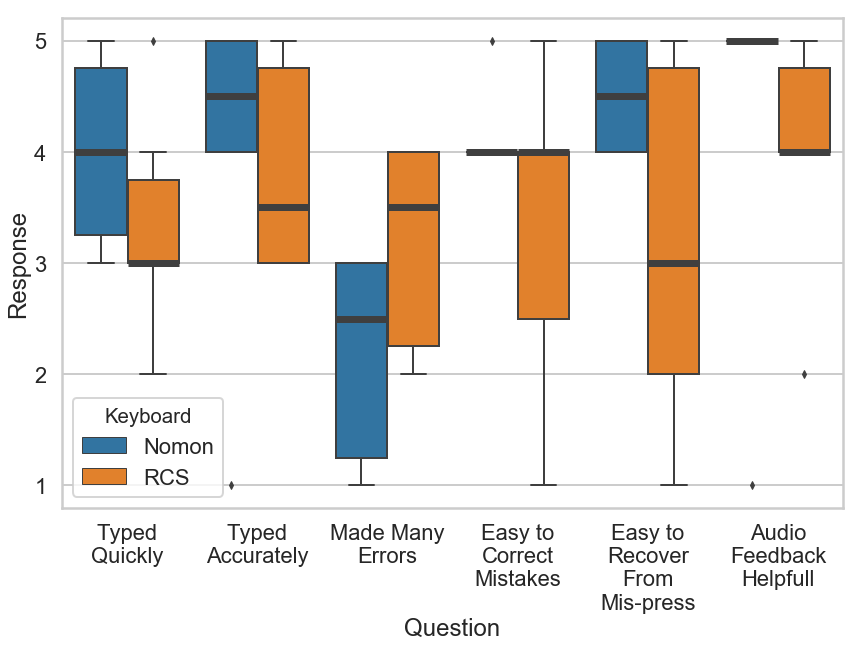

In [18]:
x_label_dict = {"type_quick": "Typed\nQuickly", "type_accurate": "Typed\nAccurately", 
                "many_errors": "Made Many\nErrors", "corr_ease": "Easy to\nCorrect\nMistakes",
                "recovery": "Easy to\nRecover\nFrom\nMis-press", "audio": "Audio\nFeedback\nHelpfull"}
keyboard_name_dict = {"A": "Nomon", "B": "RCS"}
long_df = pd.DataFrame(columns=["Question", "Keyboard", "Response"])
for row in df[df.session == 2].values:
    for question in question_columns:
        question_index = columns.index(question)  
        software_index = columns.index("software")
        
        long_df = long_df.append({"Question": x_label_dict[question], 
                        "Keyboard": keyboard_name_dict[row[software_index]], 
                        "Response": int(row[question_index])}, ignore_index=True)
long_df["Response"] = pd.to_numeric(long_df["Response"])

a4_dims = (14, 9)
fig, ax = plt.subplots(figsize=a4_dims)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
sns.set_context("poster")
sns.set_style("whitegrid")

box_plot = sns.boxplot(data=long_df, x="Question", y="Response", hue="Keyboard", ax=ax, linewidth=2)

ax = box_plot.axes
lines = ax.get_lines()

for median_line in lines[4:len(lines):6]:
    median_line.set_solid_capstyle('butt')
    median_line.set_linewidth(7)
    median_line.set_alpha(1)

plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/figures/survey_1.png")

In [45]:
for question in list(x_label_dict.values()):
    nomon_responses = long_df[(long_df.Question == question) & (long_df.Keyboard == "Nomon")].Response.values
    rowcol_responses = long_df[(long_df.Question == question) & (long_df.Keyboard == "RCS")].Response.values
    
    # question_data = np.vstack([nomon_responses, rowcol_responses]).T
    print( question, stats.mannwhitneyu(nomon_responses, rowcol_responses))

Typed
Quickly MannwhitneyuResult(statistic=11.0, pvalue=0.13657049711522518)
Typed
Accurately MannwhitneyuResult(statistic=14.0, pvalue=0.27756941492762544)
Made Many
Errors MannwhitneyuResult(statistic=8.5, pvalue=0.06790867830137579)
Easy to
Correct
Mistakes MannwhitneyuResult(statistic=13.0, pvalue=0.19502181854858003)
Easy to
Recover
From
Mis-press MannwhitneyuResult(statistic=10.5, pvalue=0.11759874751464483)
Audio
Feedback
Helpfull MannwhitneyuResult(statistic=11.0, pvalue=0.120824882882695)
